In [1]:
import pandas as pd
import numpy as np
import numpy.random as nrand
from statsmodels.distributions.empirical_distribution import ECDF, monotone_fn_inverter
import matplotlib as mpl
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes
import warnings
from scipy.misc import derivative
import scipy.stats as stats
from statsmodels.stats.multitest import multipletests
warnings.filterwarnings('ignore')

In [2]:
# Set matplotlib style
rcParams_dict = {
    'font.size': 15,
    'pdf.fonttype':42,
    'font.family':'Arial',
}
mpl.rcParams.update(rcParams_dict)

In [3]:
# Load yeast YPD datasets
Gene_list = ['ADA2','PRS3','ASC1','RAD6','BFR1','RPL29', \
             'BUD23','RPL39','CCW12','RPS7A','EOS1','SNF6','GET1',\
             'TSR2','GIM5','VMA21','IES6','VMA7','LSM1','EST1','PAF1']
df_YPD = pd.DataFrame()

# Concatenate per-gene tables, tagging each row with Gene; drop nonsense mutations
for Gene in Gene_list:
    df_gene = pd.read_csv(f'./data/Fitness_landscapes/Xukang/{Gene}.txt', 
                     delim_whitespace=True)
    df_gene['Gene'] = Gene
    df_YPD = pd.concat([df_YPD,df_gene],ignore_index=True)
df_YPD = df_YPD[df_YPD['Mutation_type'] != 'Nonsense_mutation']

# Get mean fitness effect
df_YPD['YPD_fitness'] = df_YPD[[f'Fitness_from_YPD_replicate_{i}' for i in range(1,5)]].mean(axis=1) - 1

In [4]:
# Build empirical CDF of nonsynonymous fitness
idx_nonsyn = df_YPD['Mutation_type'] == 'Nonsynonymous_mutation'
non_E_distribution = df_YPD[idx_nonsyn]['YPD_fitness'].to_numpy().flatten()
non_cdf = ECDF(non_E_distribution)

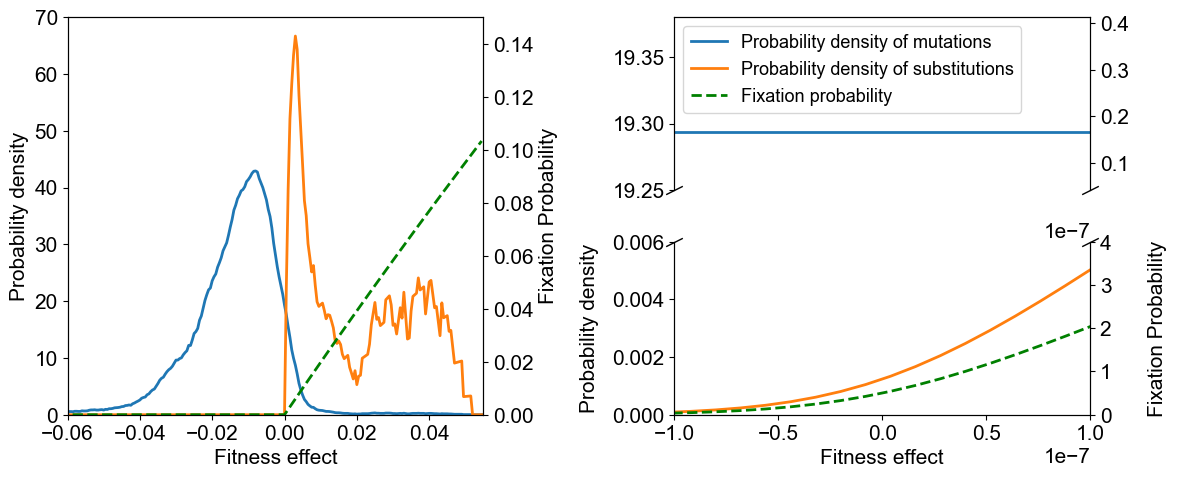

In [5]:
# Plot distributions and fixation probabilities
Ne = 1e7

# Step sizes for x-grids (left panel wider step size, right panel small step size around ~0)
interval_list = [0.0005, 0.12/Ne, 0.12/Ne]
x_range_list = [np.arange(-0.11, 0.055, interval_list[0]),
                np.arange(-2/Ne, 2/Ne, interval_list[1]),
                np.arange(-2/Ne, 2/Ne, interval_list[1])]
# Axes limits for x and y axes
xlim_list = [(-0.06, 0.055), (-1/Ne, 1/Ne), (-1/Ne, 1/Ne)]
ylim_list = [(0, 0.15), (0, 4/Ne), (0.04125, 0.4136)]

# Figure with 2x2 grid: left column big panel, right column split (top/bottom)
fig = plt.figure(figsize=(12, 5), constrained_layout=True, facecolor='w')
spec = fig.add_gridspec(2, 2)
ax0 = fig.add_subplot(spec[:, 0]) # big left
ax01 = fig.add_subplot(spec[0, 1]) # top right
ax11 = fig.add_subplot(spec[1, 1]) # bottom right

# Diagonal break markers between stacked panels on right
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)

# plot
axes = [ax0, ax11, ax01]
for i,ax1 in enumerate(axes):
    x = x_range_list[i]
    ax2 = ax1.twinx() # secondary y-axis for fixation probabilities

    # PDF of the empirical distribution via numerical derivative of ECDF
    y_YPD = derivative(non_cdf, x, dx=3e-3)
    line1 = ax1.plot(x, y_YPD, 'C0', label='Probability density of mutations', linewidth=2)

    # Fixation probability given selection coefficient x
    y_fixP = (1 - np.exp(-2 * x))/(1 - np.exp(-4 * Ne * x))

    # Normalize joint density ∝ f(mut) * P_fix so it integrates to 1 over panel 0
    if i == 0:
        denumerator = (y_YPD * y_fixP * interval_list[i]).sum()
    y_joinP = (y_YPD * y_fixP) / denumerator
    line2 = ax1.plot(x,y_joinP, 'C1', label='Probability density of substitutions', linewidth=2)
    ax1.set_xlim(xlim_list[i])

    # Plot zoom-in fixation probability on the right panel
    line3 = ax2.plot(x, y_fixP, 'g--', label='Fixation probability', linewidth=2)
    ax2.set_xlim(xlim_list[i])
    ax2.set_ylim(ylim_list[i])

    # Panel-specific formatting
    if i == 0:
        ax1.set_ylim(0, 70)
    elif i == 1:
        ax1.set_ylim(0, 0.006)
        ax1.spines.top.set_visible(False)
        ax2.spines.top.set_visible(False)
        ax1.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs) # top break mark
        ax1.yaxis.set_label_coords(-.18, 1.1) # adjust position of "Probability density" in panel B
        ax2.yaxis.set_label_coords(1.14, 1.1) # adjust position of "Fixation Probability" in panel B
    elif i == 2:
        ax1.set_ylim(19.25, 19.38)
        ax1.spines.bottom.set_visible(False)
        ax2.spines.bottom.set_visible(False)
        ax1.tick_params(labelbottom=False)  # don't put tick labels at the top
        ax1.set_xticks([])
        ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs) # bottom break mark

        # Build a single legend in the top-right panel
        lines = line1 + line2 + line3
        labs = [l.get_label() for l in lines]  
        ax1.legend(lines, labs, loc='upper left',prop={'size': 13})
        
    if i != 2:
        ax1.set_xlabel('Fitness effect')
        ax1.set_ylabel('Probability density')
        ax2.set_ylabel('Fixation Probability')
        

plt.tight_layout(pad=1)
plt.show()
#plt.savefig('../Figures/Fig1a.pdf')

In [6]:
# Compute SEs and p-values across replicates
df_YPD['YPD_se'] = df_YPD[[f'Fitness_from_YPD_replicate_{i}' for i in range(1,5)]].sem(axis=1)
df_YPD['P'] = stats.ttest_1samp(df_YPD[[f'Fitness_from_YPD_replicate_{i}' for i in range(1,5)]], 1, axis=1).pvalue

In [7]:
# Multiple testing correction (FDR) on nonsynonymous subset
_, qvals, _, _ = multipletests(df_YPD.loc[idx_nonsyn, 'P'], method='fdr_bh')
df_YPD.loc[idx_nonsyn, 'qvals'] = qvals

In [8]:
# Median effect among positive-effect nonsynonymous mutations (FDR vs raw P_value)
idx_ben = df_YPD['YPD_fitness'] > 0
idx = (df_YPD['Mutation_type'] == 'Nonsynonymous_mutation') & idx_ben
median_qvals = df_YPD.loc[(df_YPD['qvals'] < 0.05) & idx,'YPD_fitness'].median()
median_pvals = df_YPD.loc[(df_YPD['P'] < 0.05) & idx,'YPD_fitness'].median()
print(f'median s qvals: {median_qvals}\nmedian s pvals: {median_pvals}')

median s qvals: 0.01096740949999997
median s pvals: 0.01068017612499994


In [9]:
# Fractions of significant beneficial nonsynonymous mutations (FDR vs raw p)
frac_qvals = (idx_nonsyn & idx_ben & (df_YPD['qvals'] < 0.05)).sum() / idx_nonsyn.sum()
frac_pvals = (idx_nonsyn & idx_ben & (df_YPD['P'] < 0.05)).sum() / idx_nonsyn.sum()
print(f'ben frac qvals: {frac_qvals}\nben frac pvals: {frac_pvals}')

ben frac qvals: 0.014906438312718047
ben frac pvals: 0.01585791309863622


In [ ]:
# Non-overlapping error-bar stacking

# Sort by P so the most significant points tend to be placed first
df_YPD = df_YPD.sort_values(by='P')
idx_ben = df_YPD['YPD_fitness'] > 0
idx_nonsyn = df_YPD['Mutation_type'] == 'Nonsynonymous_mutation'

y_dict = {} # {y: fitness +/- SE}
y_list = []

# Greedy assignment of rows to the lowest y whose intervals do not overlap
for i, row in df_YPD[idx_ben & idx_nonsyn].iterrows():
    fitness = row['YPD_fitness']
    se = row['YPD_se']
    
    y = 0
    while True:
        if y not in y_dict:
            y_dict[y] = [(fitness - se, fitness + se)]
            break
        else:
            # Check overlap with existing intervals on this y-row
            flag = True
            for lower, upper in y_dict[y]:
                if (fitness + se < lower) or (fitness - se > upper):
                    continue
                else:
                    flag = False
                    break
            if flag:
                y_dict[y].append((fitness - se, fitness + se))
                break
            else:
                y += 1
    y_list.append(y)

([], [])

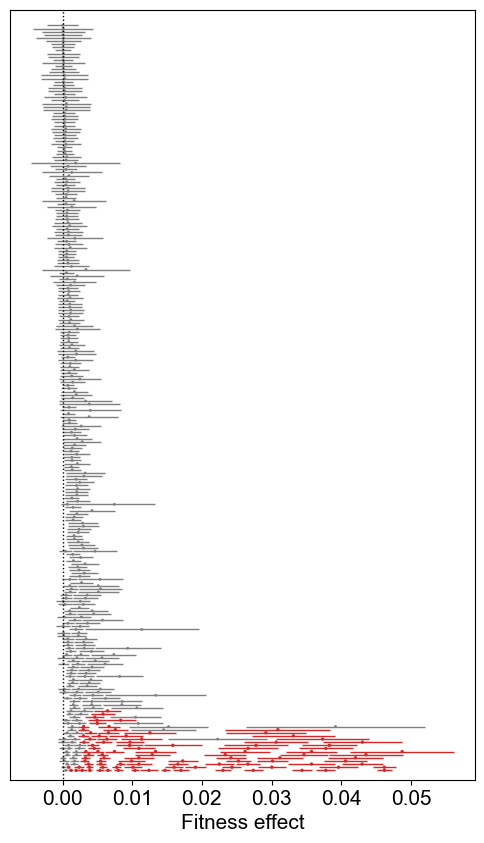

In [12]:
# Plot non-overlapping error-bar stacking for each fitness effect

plt.subplots(figsize=[6, 10])

plt.scatter(
    df_YPD.loc[idx_ben & idx_nonsyn, 'YPD_fitness'], 
    y_list,
    s=[2 if P < 0.05 else 1 for P in df_YPD.loc[idx_ben & idx_nonsyn, 'P']], 
    color=['C3' if P < 0.05 else 'C7' for P in df_YPD.loc[idx_ben & idx_nonsyn, 'P']]
)

plt.errorbar(
    x=df_YPD.loc[idx_ben & idx_nonsyn, 'YPD_fitness'],
    y=y_list,
    xerr=df_YPD.loc[idx_ben & idx_nonsyn, 'YPD_se'],
    fmt='none',
    ecolor=['C3' if P < 0.05 else 'C7' for P in df_YPD.loc[idx_ben & idx_nonsyn, 'P']],
    elinewidth=1
)
plt.vlines(x=0, ymin=-5, ymax=250, color='k', ls=':', lw=1)
plt.xlabel('Fitness effect')
plt.ylim(-3, 243)
plt.yticks([])
#plt.savefig('../Figures/FigS1a.pdf')